## Yelp Photo Classification with CNN from Scratch.

Note that the train, test and the valid dataset contains 5 classes: food, menu, outside, interior and drink. Here the train folder has 6000 images, the validation and test folder has 1000 images respectively.

In [1]:
# General Libs
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from pathlib import Path
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Create a path to the train, test & valid folder

In [3]:
train_path = '/content/drive/MyDrive/yelpdata/train_dir'
test_path = '/content/drive/MyDrive/yelpdata/test_dir'
valid_path = '/content/drive/MyDrive/yelpdata/valid_dir'

In [4]:
train_folder = Path(train_path)
test_folder = Path(test_path)
valid_folder=Path(valid_path)

In [5]:
train_size = 6000
valid_size = 1000
test_size = 1000
img_height = 224
img_width = 224
n_classes = 5
batch_size = 32
n_epochs = 20

### Create CNN model from Scratch for Classification

In [6]:
# Standardize the data
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create batches of data from each set train, test and validation)
train_ds = datagen.flow_from_directory(directory=train_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True)

valid_ds = datagen.flow_from_directory(directory=valid_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False)

test_ds = datagen.flow_from_directory(directory=test_folder,
                                              target_size=(img_height,
                                                           img_width),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=False)

Found 6000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


Check the label dictionary for the test dataset

In [7]:
print('Number of samples: ',test_ds.samples)
print('Number of classes: ',len(test_ds.class_indices))
print('Number of samples per class:', int(test_ds.samples/len(test_ds.class_indices)))

Number of samples:  1000
Number of classes:  5
Number of samples per class: 200


In [8]:
labels = {value: key for key, value in test_ds.class_indices.items()}

print("Label Mappings for classes present in the test dataset\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the test dataset

0 : drink
1 : food
2 : interior
3 : menu
4 : outside


In [9]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


Let us see what are the images in the test generator

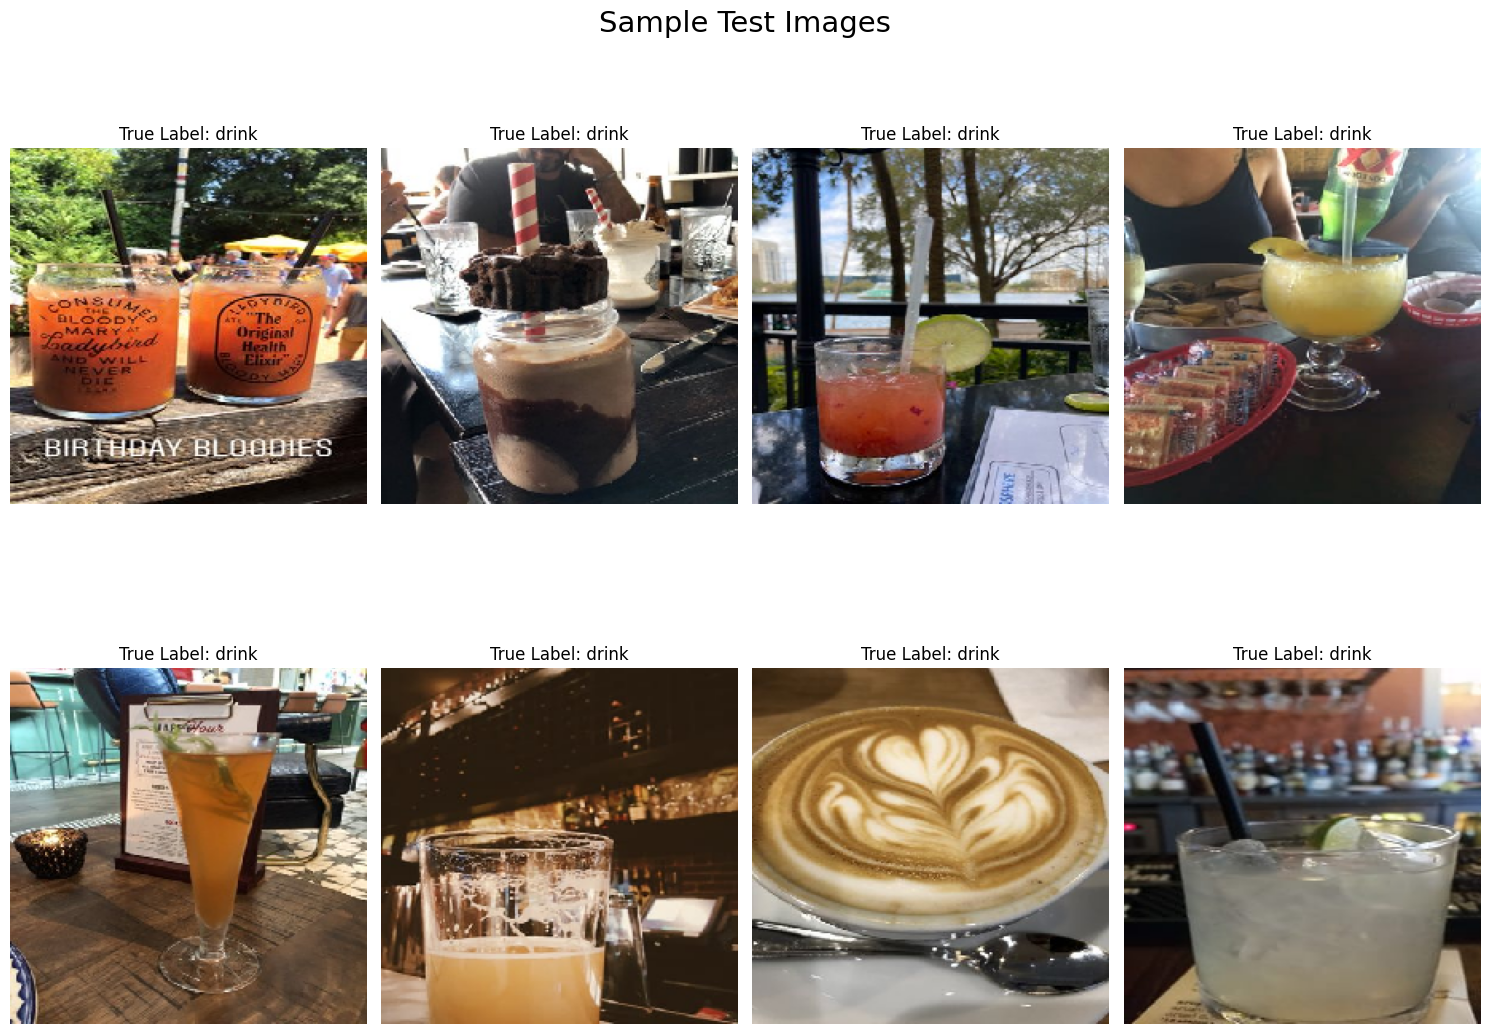

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(test_ds[0][1][idx])]
        ax[i, j].set_title(f"True Label: {label}")
        ax[i, j].imshow(test_ds[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Test Images", fontsize=21)
plt.show()

### Create a CNN classification model from scratch

In [11]:
def create_model():
    model = Sequential([
        Conv2D(128, kernel_size=(5, 5), padding='same', input_shape=(img_width, img_height, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    return model

In [12]:
full_model = create_model()
full_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,526,949 (24.90 MB)

 Trainable params: 6,526,501 (24.90 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Utilize the Adam Optimizers
opt = keras.optimizers.Adam(learning_rate=1e-5)
full_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


# Use Early Stopping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

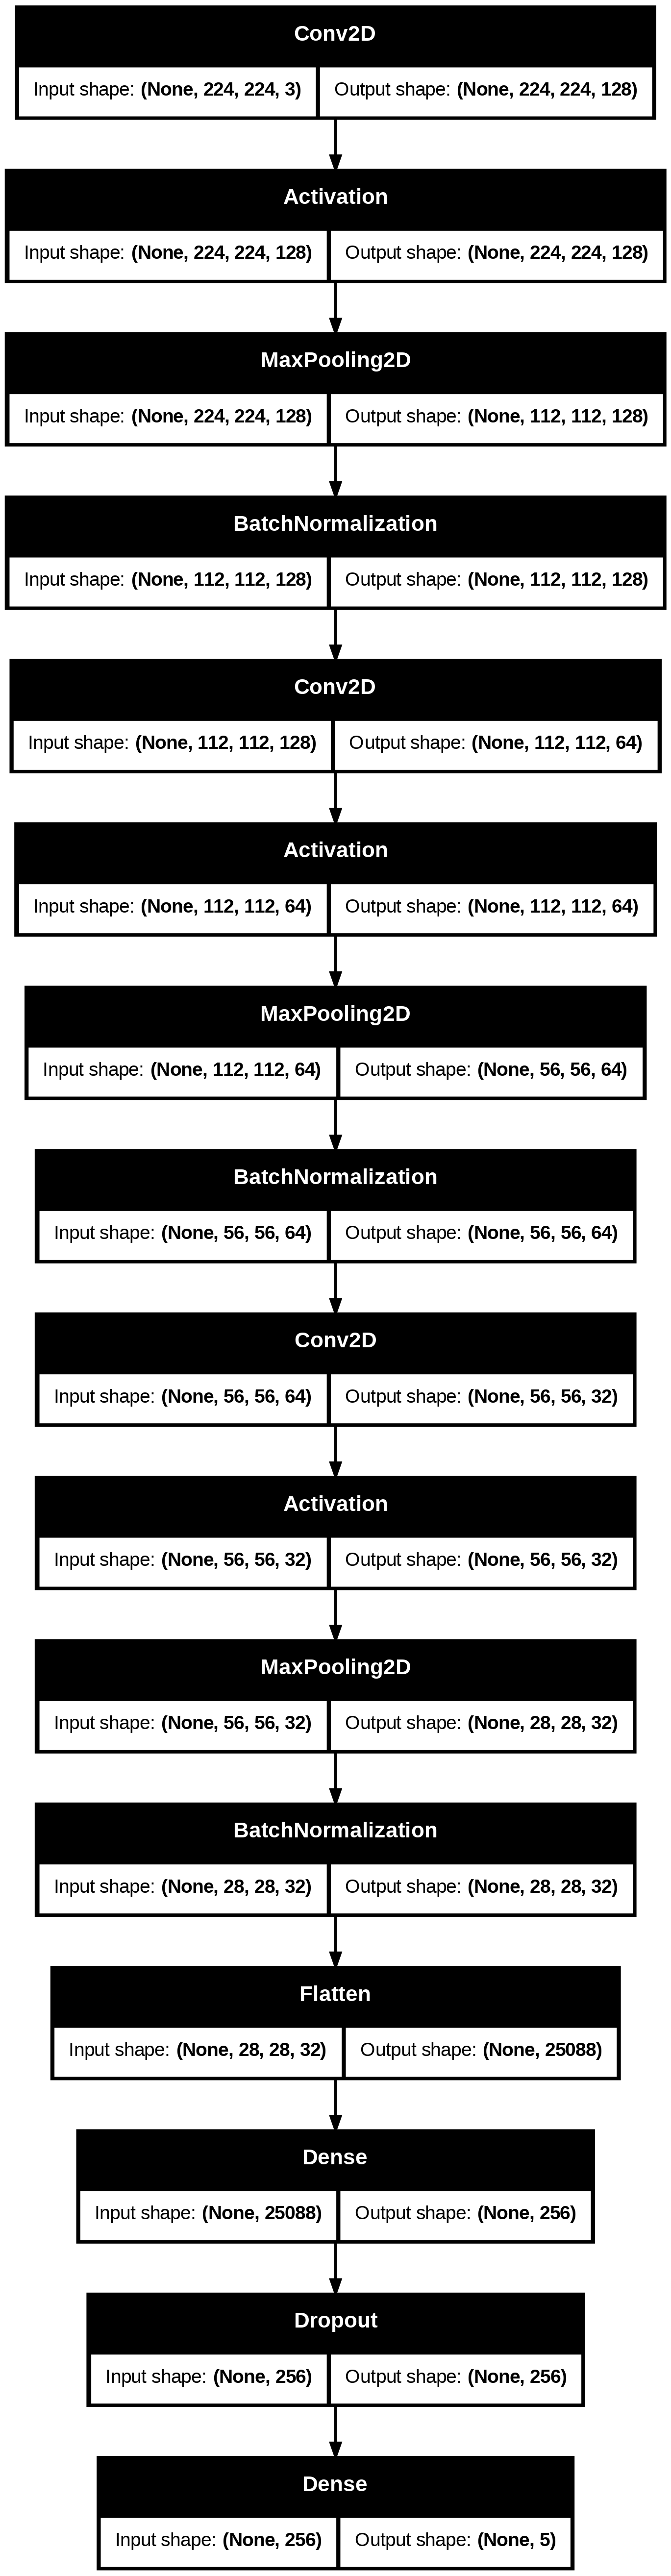

In [14]:
# Plot the model
dot_img_file = 'model_cnn.png'
tf.keras.utils.plot_model(full_model, to_file=dot_img_file, show_shapes=True)

In [15]:
history = full_model.fit(train_ds,epochs=n_epochs,
                               validation_data=valid_ds,
                               steps_per_epoch=train_size // batch_size,
                               validation_steps=valid_size // batch_size,
                               callbacks=[es])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 2635s 14s/step - accuracy: 0.3551 - loss: 2.0285 - val_accuracy: 0.2218 - val_loss: 2.4141
Epoch 2/20
  1/187 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.5000 - loss: 1.7551

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5000 - loss: 1.7551 - val_accuracy: 0.0000e+00 - val_loss: 5.2014
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.5565 - loss: 1.2468 - val_accuracy: 0.3337 - val_loss: 2.1866
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6875 - loss: 0.9519 - val_accuracy: 0.0000e+00 - val_loss: 5.5550
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.6155 - loss: 1.0312 - val_accuracy: 0.5161 - val_loss: 1.3455
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5938 - loss: 1.0176 - val_accuracy: 0.2500 - val_loss: 3.2392
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 77s 242ms/step - accuracy: 0.7173 - loss: 0.7897 - val_accuracy: 0.6280 - val_loss: 0.9675
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 144us/step - accuracy: 0.8438 - loss: 0.4225 - val_accuracy: 0.3750 - val_loss: 1.6959
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 245ms/step - accuracy: 0.7331 - loss: 0.7236 - va

### Save the model as a h5 file

In [16]:
full_model.save('/content/drive/MyDrive/yelpdata/CNNSCRATCH.h5')

### Plot the learning curves

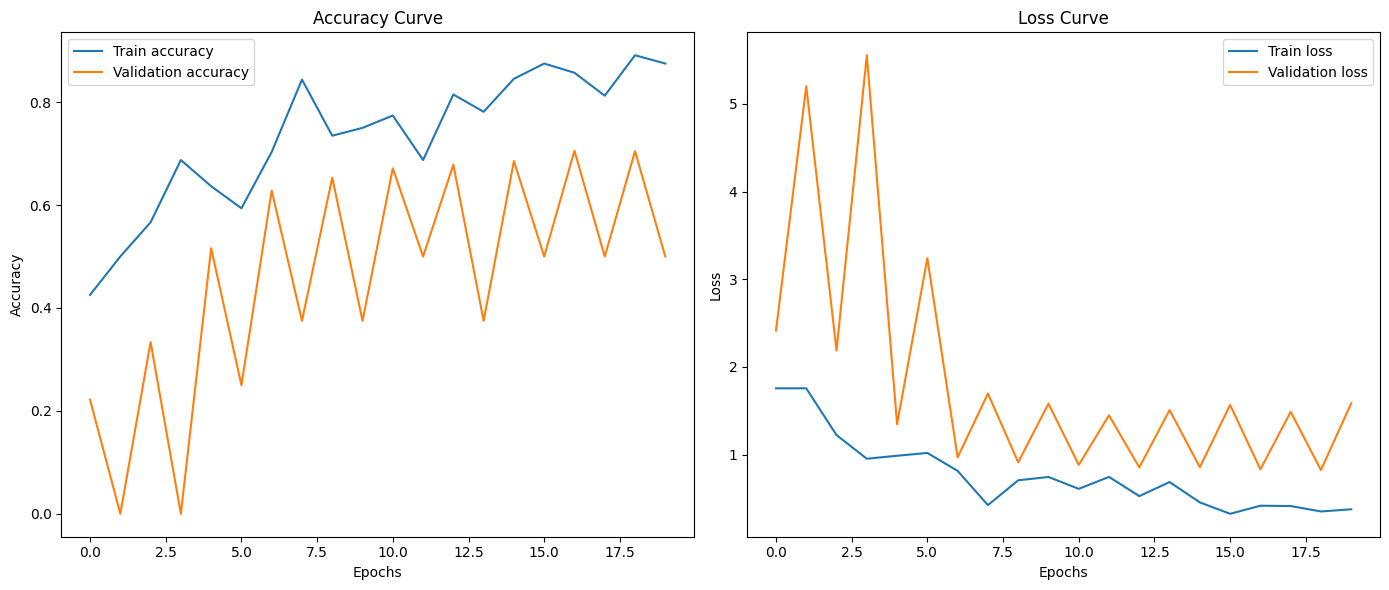

In [17]:
# Plot the learning curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot loss
axes[1].plot(history.history['loss'], label='Train loss')
axes[1].plot(history.history['val_loss'], label='Validation loss')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Predict the model performance on the test dataset

In [18]:
test_loss, test_accuracy = full_model.evaluate(test_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 311s 10s/step - accuracy: 0.6614 - loss: 0.9136


In [19]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.820909857749939
Test Accuracy: 0.699999988079071


In [20]:
model = load_model('/content/drive/MyDrive/yelpdata/CNNSCRATCH.h5')

In [21]:
preds = model.predict(test_ds, batch_size=batch_size)

y_pred=np.argmax(preds,axis=1)
y_true = test_ds.classes

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step


### Plot the Classification matrix

In [22]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(test_ds.classes, y_pred)

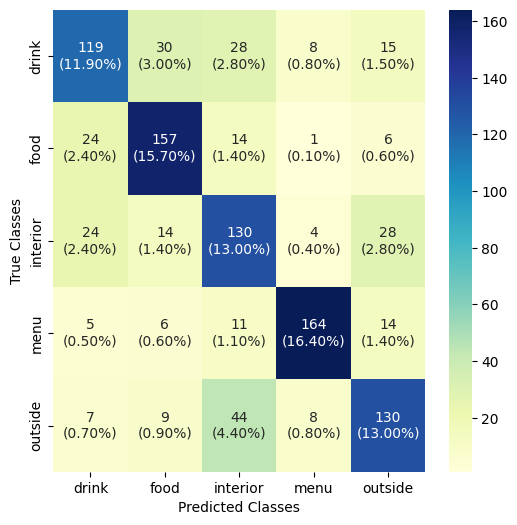

In [23]:
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5, 5)

plt.figure(figsize = (6, 6))
sns.heatmap(cm, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

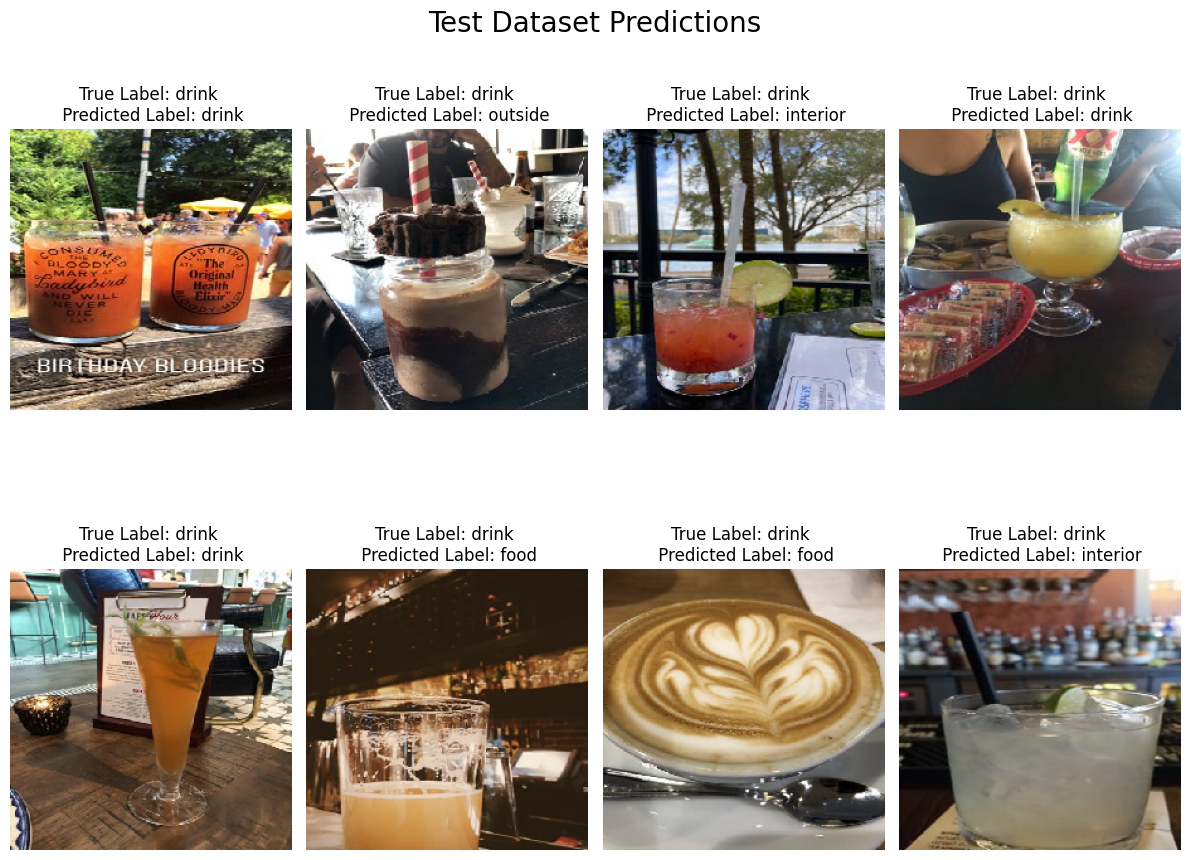

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        predicted_label = labels[np.argmax(preds[idx])]
        ax[i, j].set_title(f"True Label: {label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_ds[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()